In [3]:
!pip install d2l

In [4]:
import time
from scipy import stats
from d2l import torch as d2l

In [5]:
class HPOSearcher(d2l.HyperParameters):
    def sample_configuration() -> dict:
        raise NotImplementedError

    def update(self, config: dict, error: float, additional_info=None):
        pass

In [6]:
class RandomSearcher(HPOSearcher):
    def __init__(self, config_space: dict, initial_config=None):
        self.save_hyperparameters()

    def sample_configuration(self) -> dict:
        if self.initial_config is not None:
            result = self.initial_config
            self.initial_config = None
        else:
            result = {
                name: domain.rvs()
                for name, domain in self.config_space.items()
            }
        return result

In [7]:
class HPOScheduler(d2l.HyperParameters):
    def suggest(self) -> dict:
        raise NotImplementedError

    def update(self, config: dict, error: float, info=None):
        raise NotImplementedError

In [8]:
class BasicScheduler(HPOScheduler):
    def __init__(self, searcher: HPOSearcher):
        self.save_hyperparameters()

    def suggest(self) -> dict:
        return self.searcher.sample_configuration()

    def update(self, config: dict, error: float, info=None):
        self.searcher.update(config, error, additional_info=info)

In [9]:
class HPOTuner(d2l.HyperParameters):
    def __init__(self, scheduler: HPOScheduler, objective: callable):
        self.save_hyperparameters()
        # Bookeeping results for plotting
        self.incumbent = None
        self.incumbent_error = None
        self.incumbent_trajectory = []
        self.cumulative_runtime = []
        self.current_runtime = 0
        self.records = []

    def run(self, number_of_trials):
        for i in range(number_of_trials):
            start_time = time.time()
            config = self.scheduler.suggest()
            print(f"Trial {i}: config = {config}")
            error = self.objective(**config)
            error = float(error.cpu().detach().numpy())
            self.scheduler.update(config, error)
            runtime = time.time() - start_time
            self.bookkeeping(config, error, runtime)
            print(f"    error = {error}, runtime = {runtime}")

In [10]:
@d2l.add_to_class(HPOTuner)
def bookkeeping(self, config: dict, error: float, runtime: float):
    self.records.append({"config": config, "error": error, "runtime": runtime})
    # Check if the last hyperparameter configuration performs better
    # than the incumbent
    if self.incumbent is None or self.incumbent_error > error:
        self.incumbent = config
        self.incumbent_error = error
    # Add current best observed performance to the optimization trajectory
    self.incumbent_trajectory.append(self.incumbent_error)
    # Update runtime
    self.current_runtime += runtime
    self.cumulative_runtime.append(self.current_runtime)

In [11]:
def hpo_objective_lenet(learning_rate, batch_size, max_epochs=10):
    model = d2l.LeNet(lr=learning_rate, num_classes=10)
    trainer = d2l.HPOTrainer(max_epochs=max_epochs, num_gpus=1)
    data = d2l.FashionMNIST(batch_size=batch_size)
    model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
    trainer.fit(model=model, data=data)
    validation_error = trainer.validation_error()
    return validation_error

In [12]:
config_space = {
    "learning_rate": stats.loguniform(1e-2, 1),
    "batch_size": stats.randint(32, 256),
}
initial_config = {
    "learning_rate": 0.1,
    "batch_size": 128,
}

    error = 0.28859037160873413, runtime = 395.5114896297455


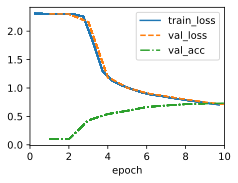

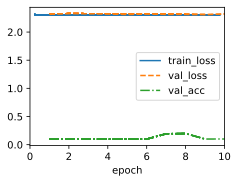

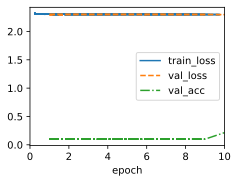

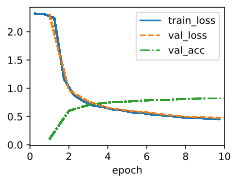

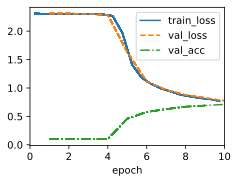

In [13]:
searcher = RandomSearcher(config_space, initial_config=initial_config)
scheduler = BasicScheduler(searcher=searcher)
tuner = HPOTuner(scheduler=scheduler, objective=hpo_objective_lenet)
tuner.run(number_of_trials=5)

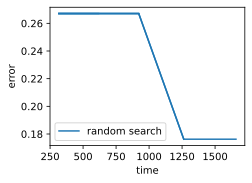

In [15]:
board = d2l.ProgressBoard(xlabel="time", ylabel="error")
for time_stamp, error in zip(
    tuner.cumulative_runtime, tuner.incumbent_trajectory
):
    board.draw(time_stamp, error, "random search", every_n=1)